# Pneumonia classification with NIH Chest X-ray Dataset
The following notebook focuses on the analysis of the dataset containing images taken with an X-ray machine. In it, I will focus on getting to know the data set and preparing it to be used for prediction using convolutional neural networks.

### Import all necessary libraries

In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom

In [9]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
56556,00014073_007.png,No Finding,7,14073,57,M,PA,2500,2048,0.168,0.168,NaN
80108,00019682_002.png,No Finding,2,19682,32,F,PA,2798,2601,0.143,0.143,NaN
14877,00003882_001.png,No Finding,1,3882,51,M,AP,2500,2048,0.171,0.171,NaN


In [10]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4711,00024080_000.png,No Finding,0,24080,030Y,M,PA,2500,2048,0.168,0.168
4638,00023191_000.png,No Finding,0,23191,050Y,M,PA,3056,2544,0.139,0.139
3220,00015886_001.png,No Finding,1,15886,075Y,F,AP,2500,2048,0.168,0.168


<h3>EDA</h3>

First look at some abnormalities (if exists) in dataframe

In [21]:
all_xray_df.loc[all_xray_df["Patient Age"] > 100][["Patient ID", "Patient Age"]]

,Patient ID,Patient Age
20852,5567,412
46965,11973,414
48284,12238,148
55742,13950,148
58650,14520,150
62929,15558,149
74884,18366,152
78795,19346,151
84810,20900,411
85404,21047,412


Well we do have some really old patients here! As far as I know none of numbers above are possible. I will remove them from my further analysis.

In [22]:
all_xray_df = all_xray_df.loc[all_xray_df["Patient Age"] <= 100]

Now we can display our age distribution

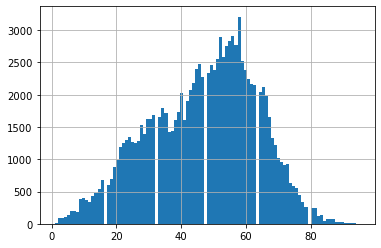

In [26]:
all_xray_df["Patient Age"].hist(bins=100);

Most of the patients are between 50 and 60 years old, but we have quite a lot of data from a really wide range of ages. Now let's look at another important feature which is gender.

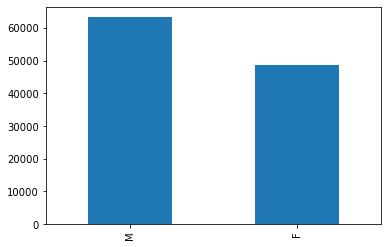

In [65]:
all_xray_df["Patient Gender"].value_counts().plot(kind="bar");

In the data frame there is a visible skew between the number of males and females. We need to remember that during the training data split.

So how about diseases? How many types of them can we find in our dataset?

In [30]:
all_xray_df["Finding Labels"].value_counts()

No Finding                                                         60353
Infiltration                                                        9546
Atelectasis                                                         4214
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Effusion|Fibrosis|Infiltration|Mass                                    1
Atelectasis|Consolidation|Effusion|Fibrosis|Pleural_Thickening         1
Effusion|Nodule|Pleural_Thickening|Mass                                1
Atelectasis|Consolidation|Emphysema|Mass|Pleural_Thickening            1
Atelectasis|Emphysema|Fibrosis|Infiltration|Nodule|Pneumothorax        1
Name: Finding Labels, Length: 836, dtype: int64

That doesn't tell us much. We need to split those labels into individual columns. There is multiple ways to do that, one of them could be:

In [51]:
diseases = []
for val in all_xray_df["Finding Labels"]:
    diseases.extend(val.split("|")) # We can do that because there is no NaNs.
                                    # Otherwise we should use try/except block with AttributeError
diseases = list(sorted(set(diseases)))
    
print(f"Num of diseases found: {len(diseases)}. \nDiseases: {diseases}")

Num of diseases found: 15. 
Diseases: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [52]:
def split_label(label, disease):
    return 1 if label.find(disease) > -1 else 0

In [53]:
for disease in diseases:
    all_xray_df[disease] = all_xray_df["Finding Labels"].apply(lambda x: split_label(x, disease))

In [70]:
diseases_df = all_xray_df.iloc[:, 12:12+len(diseases)]
diseases_df.head(5)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


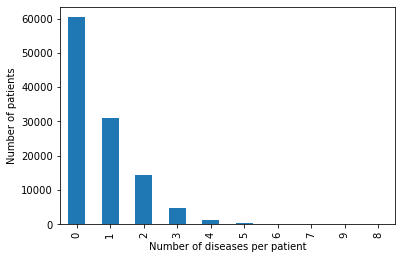

In [110]:
ax = diseases_df.loc[:, diseases_df.columns != "No Finding"].sum(axis=1).value_counts().plot(kind="bar");
ax.set_xlabel("Number of diseases per patient");
ax.set_ylabel("Number of patients");

As we can see most patients has no diseases and the number of patients with one ailment is halved. We also see that a few poor people have up to five diseases!

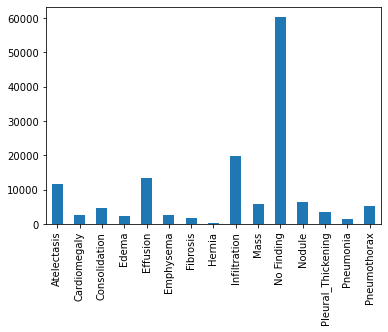

In [71]:
diseases_df.sum(axis=0).plot(kind="bar");

The most popular is definitely label "No Finding", that's good news for those patients, worse for us because we are facing an imbalanced dataset. But we could expect that from medical data. The other popular diseases are Infiltration, Effusion, and Atelectasis. However, today we are most interested in Pneumonia. Let's see how many patients from our dataset has this condition.

In [75]:
diseases_df.sum()["Pneumonia"]

1430

In [100]:
# Non pneumonia cases
diseases_df.sum().sum() - diseases_df.sum()["Pneumonia"]

140087

Now we can check some of the co-occurrences between patients "features" and his diseases

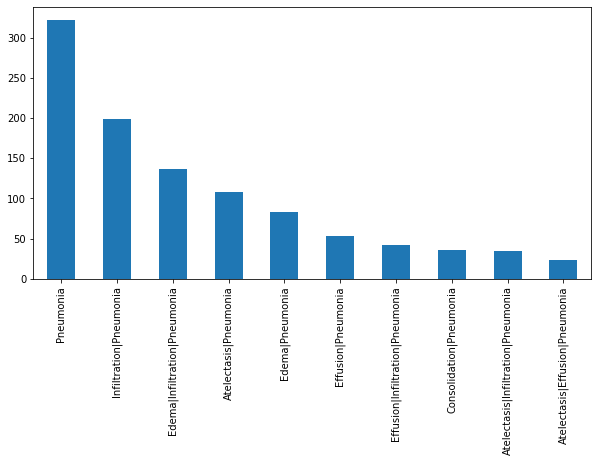

In [79]:
plt.figure(figsize=(10,5))
all_xray_df[all_xray_df.Pneumonia == 1]['Finding Labels'].value_counts()[:10].plot(kind='bar');

It looks like Pneumonia occurs alone for the most part, and that its most-common comorbidities are Infiltration, Atelectasis and Effusion.

Text(0.5, 1.0, 'All patients')

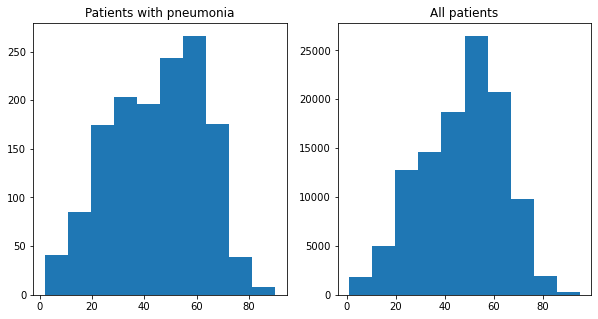

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(all_xray_df[all_xray_df.Pneumonia == 1]["Patient Age"]);
ax1.set_title("Patients with pneumonia");

ax2.hist(all_xray_df["Patient Age"]);
ax2.set_title("All patients");

It looks like the distribution of age across the whole population is quite similar as specifically for Pneumonia.

Text(0.5, 1.0, 'All patients')

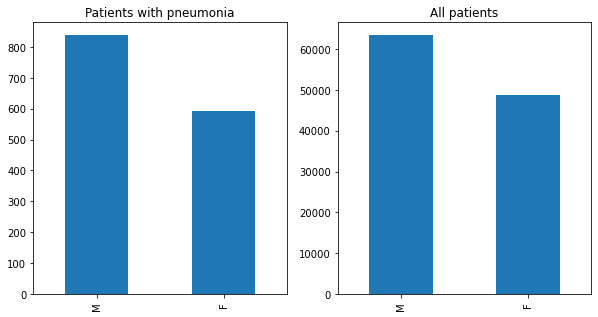

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

all_xray_df[all_xray_df.Pneumonia == 1]["Patient Gender"].value_counts().plot(kind="bar", ax=ax1);
ax1.set_title("Patients with pneumonia")

all_xray_df["Patient Gender"].value_counts().plot(kind="bar", ax=ax2);
ax2.set_title("All patients")

So they are about the same distribution.

<h3>Images attributes</h3>

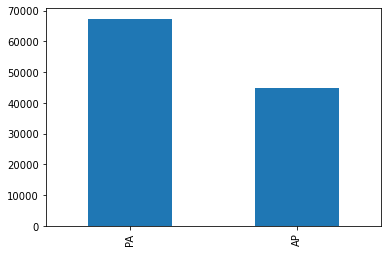

In [114]:
all_xray_df["View Position"].value_counts().plot(kind="bar");

Posteroanterior (PA) chest view is the most common radiological investigation in the emergency department. The PA view examines the lungs, bony thoracic cavity, mediastinum and great vessels. As we can see, this is the majority of cases in our collection.

The AP shows magnification of the heart and widening of the mediastinum. AP views are less useful and should be reserved for very ill patients who cannot stand erect.

PA radiograph is obtained with the x-ray traversing the patient from posterior to anterior and striking the film. Similarly an AP radiograph is positioned with the xray traversing the patient from anterior to posterior striking the film.

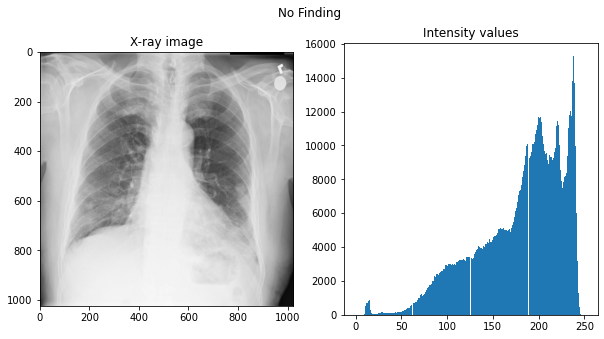

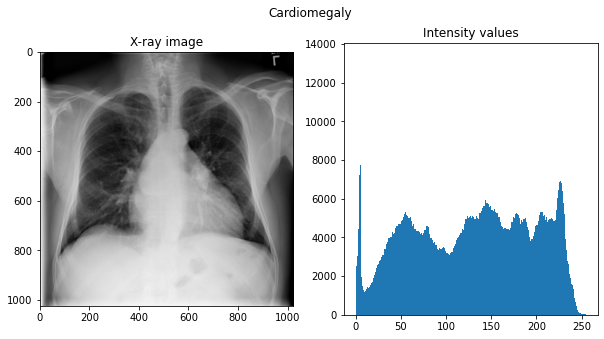

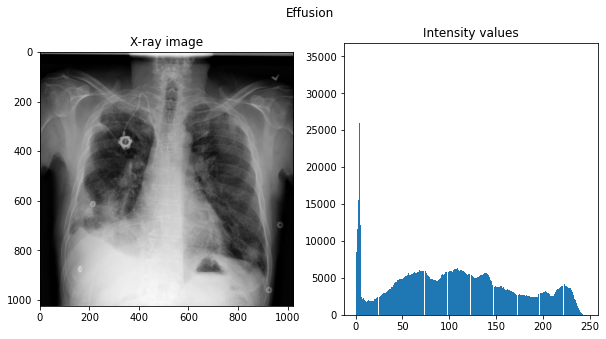

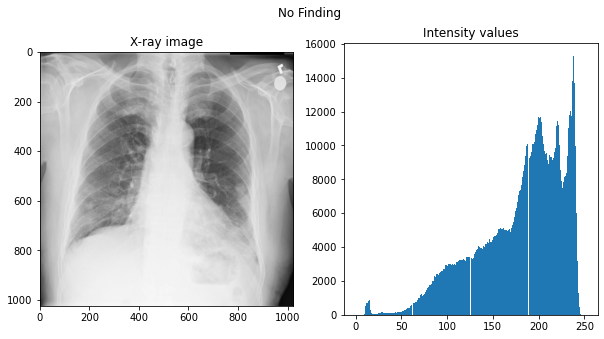

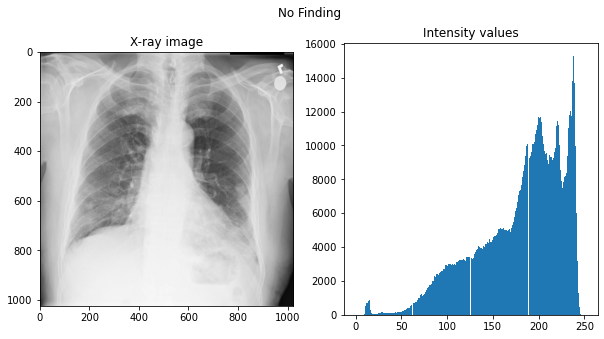

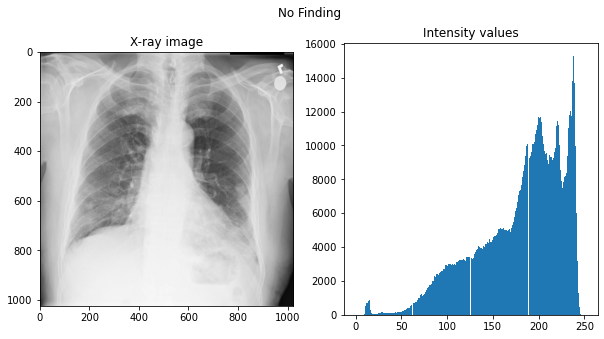

In [135]:
dcm_files_list = sorted([file for file in glob("*.dcm")])
dcm_files = [pydicom.dcmread(file) for file in dcm_files_list]

for dcm in dcm_files:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(dcm.pixel_array, cmap="gray")
    ax1.set_title("X-ray image")
    
    ax2.hist(dcm.pixel_array.ravel(), bins = 256)
    ax2.set_title("Intensity values")
    fig.suptitle(dcm.StudyDescription)

From images and histograms above we can see that x-rays images with some disease has different intensity distribution than images from healthy people.